##### Start

In [6]:
# import phi.torch
from PIL import Image
import torch
from phi.torch.flow import *

class NavigationNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Linear(6, 16),  # Input: [bot_x, bot_y, goal_x, goal_y, world_theta, relative_theta]
            torch.nn.ReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
        )
        self.linear_head = torch.nn.Sequential(
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()  # L will be in [0,1]
        )
        self.angular_head = torch.nn.Sequential(
            torch.nn.Linear(16, 1),
            torch.nn.Tanh()  # delta_theta will be in [-1,1]
        )
        
    def forward(self, current_state):
        features = self.features(current_state)
        L = self.linear_head(features).squeeze(-1)  # shape: (batch,)
        delta_theta = self.angular_head(features).squeeze(-1)  # shape: (batch,)
        # Stack outputs into one tensor of shape (batch, 2)
        return torch.stack([L, delta_theta], dim=-1)

In [7]:
def simulate_trajectory(net, initial_pos, goal_pos, max_steps=20):
    current_pos = initial_pos
    theta = math.zeros(initial_pos.shape.non_channel)
    total_loss = 0
    path_length = 0  # Track total distance traveled
    prev_controls = None  # For control smoothness
    net = net.to('cuda')
    trajectory = [current_pos]

    eps = 1e-6

    import re  # For regex to extract device name.
    
    for step in range(max_steps):
        delta_pos = goal_pos - current_pos

        # Use an increasing temporal weight to emphasize later steps.
        # temporal_weight = (step + 1) / max_steps
        temporal_weight = 0.85 ** (step*-1)
        
        # Calculate relative angle between goal and current position.
        relative_theta = math.arctan(delta_pos.vector['y'], divide_by=delta_pos.vector['x'] + eps) - theta
        relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi 
        
        # Assemble network input (normalize the features).
        net_input = math.stack([
            current_pos.vector['x'] / 8, 
            current_pos.vector['y'] / 6,
            goal_pos.vector['x'] / 8,
            goal_pos.vector['y'] / 6,
            theta / math.PI,
            relative_theta / math.PI
        ], channel('input_features'))
        
        # Get the network prediction.
        controls = math.native_call(net, net_input)
        L = controls.vector[0]
        # Extract the actual device identifier from net_input.device.
        raw_device_str = str(net_input.device)
        match = re.search(r"GPU '([^']+)'", raw_device_str)
        if match:
            dev_str = match.group(1)  # For example, 'cuda:0'
        else:
            dev_str = 'cpu'
        device = torch.device(dev_str)
        
        # Generate noise using torch.
        # noise = torch.rand((1,), device=device).item() * 0.5 * math.PI  
        noise = np.random.uniform(low=-(1/6), high=(1/6), size=1)[0]*math.PI
        # Scale the angular output appropriately.
        delta_theta = controls.vector[1] * math.PI + noise
        delta_theta = (delta_theta + math.PI) % (2 * math.PI) - math.PI

        # Add a smoothness penalty for changes in control.
        if prev_controls is not None:
            control_change = math.vec_squared(controls - prev_controls)
            total_loss += 0.25 * math.mean(control_change)
        prev_controls = controls

        # Update orientation.
        theta += delta_theta
        theta = (theta + np.pi) % (2 * math.PI) - math.PI 
        
        # Calculate movement.
        delta_x = L * math.cos(theta)
        delta_y = L * math.sin(theta)
        movement = math.stack([delta_x, delta_y], dim=channel(vector='x,y'))

        # Track path length using norm.
        path_length += math.norm(movement)
        
        # Update position.
        new_pos = current_pos + movement
        trajectory.append(new_pos)

        # Calculate losses.
        position_loss = temporal_weight * math.norm(delta_pos)
        control_loss = 0.1 * math.abs(delta_theta)
        total_loss += math.mean(position_loss + control_loss)
        
        # Only update the position if still far from obstacle or goal.
        current_pos = math.where(math.norm(delta_pos) > 0.1, new_pos, current_pos)
    
    final_pos_loss = 10.0 * math.norm(trajectory[-1] - goal_pos)
    
    straight_line_dist = math.norm(goal_pos - initial_pos)
    efficiency_loss = 0.9 * (path_length / (straight_line_dist + eps))
    
    return total_loss + math.mean(final_pos_loss + efficiency_loss)

In [8]:
def generate_batch(batch_size, min_distance=0.1, max_distance=20):
    batch_dim = batch(samples=batch_size)
    vec_dim = channel(vector='x,y')
    
    # Generate initial positions
    initial_x = math.random_uniform(batch_dim, low=-8, high=8)
    initial_y = math.random_uniform(batch_dim, low=-6,  high=6)
    initial_pos = math.stack([initial_x, initial_y], vec_dim)
    
    # Generate random displacement direction (angles)
    angle = math.random_uniform(batch_dim, low=-math.pi, high=math.pi)
    
    # Generate displacement magnitudes between [min_distance, 2*min_distance]
    distance = math.random_uniform(batch_dim, low=min_distance, high=max_distance)
    
    # Compute displacement components
    dx = distance * math.cos(angle)
    dy = distance * math.sin(angle)
    
    # Apply displacement to initial positions
    goal_x = (initial_x + dx)
    goal_y = (initial_y + dy)
    
    # Clamp goals to stay within bounds
    goal_x = math.clip(goal_x, -7.9, 7.9)
    goal_y = math.clip(goal_y, -5.9, 5.9)
    
    goal_pos = math.stack([goal_x, goal_y], vec_dim)
    
    return initial_pos, goal_pos

In [9]:
def physics_loss(net, initial_pos, goal_pos):
    return simulate_trajectory(net, initial_pos, goal_pos)

In [10]:
import numpy as np
import cv2

def get_lidar_points(binary_img, current_pos, world_limits, num_rays=360, max_range=4.0):
    """
    Get LiDAR first contact points in world coordinates using vectorized operations
    Args:
        binary_img: Binary image where 0 is obstacle, 1 is free space
        current_pos: (x,y) position of the sensor in world coordinates
        world_limits: Array of [[min_x, max_x], [min_y, max_y]] world boundaries
        num_rays: Number of rays to cast (default 360 for 1-degree resolution)
        max_range: Maximum range of the sensor in world units
    Returns:
        points: Array of shape (360,2) with (x,y) coordinates relative to sensor position,
               zeros for rays that don't hit anything
    """
    height, width = binary_img.shape
    # Calculate transformation factors from world to image
    world_width = world_limits[0][1] - world_limits[0][0]
    world_height = world_limits[1][1] - world_limits[1][0]
    scale_x = width / world_width
    scale_y = height / world_height
    # Convert world position to image coordinates
    img_x = int((current_pos[0] - world_limits[0][0]) * scale_x)
    img_y = height - int((current_pos[1] - world_limits[1][0]) * scale_y)
    # Convert max_range to pixels
    max_range_px = int(max_range * min(scale_x, scale_y))
    # Generate all angles at once
    angles = np.linspace(0, 2*np.pi, num_rays, endpoint=False)
    # Generate direction vectors for all angles
    directions = np.stack([np.cos(angles), -np.sin(angles)], axis=0)  # Shape: (2, num_rays)
    # Generate all ray lengths at once
    ray_lengths = np.arange(1, max_range_px)  # Shape: (max_range_px-1,)
    # Calculate all possible points for all rays using broadcasting
    ray_points = (ray_lengths[:, np.newaxis, np.newaxis] * directions[np.newaxis, :, :])
    ray_points = np.transpose(ray_points, (0, 2, 1))  # Reshape to (max_range_px-1, num_rays, 2)
    # Add sensor position to all points
    ray_points_x = ray_points[..., 0] + img_x  # Shape: (max_range_px-1, num_rays)
    ray_points_y = ray_points[..., 1] + img_y
    # Convert to integer coordinates
    ray_points_x = ray_points_x.astype(np.int32)
    ray_points_y = ray_points_y.astype(np.int32)
    # Create masks for valid points
    valid_x = (ray_points_x >= 0) & (ray_points_x < width)
    valid_y = (ray_points_y >= 0) & (ray_points_y < height)
    valid_points = valid_x & valid_y
    # Initialize array to store contact points (replacing the contact_points list)
    contact_points = np.zeros((num_rays, 2))
    lidar_dists = np.ones(num_rays) * np.inf
    # Find first contact points for each ray
    for ray_idx in range(num_rays):
        valid_ray_points = valid_points[:, ray_idx]
        if not np.any(valid_ray_points):
            continue
        ray_x = ray_points_x[valid_ray_points, ray_idx]
        ray_y = ray_points_y[valid_ray_points, ray_idx]
        # Check for obstacles along the ray
        ray_values = binary_img[ray_y, ray_x]
        obstacle_indices = np.where(ray_values == 0)[0]
        if len(obstacle_indices) > 0:
            # Get first contact point
            first_contact_idx = obstacle_indices[0]
            px = ray_x[first_contact_idx]
            py = ray_y[first_contact_idx]
            # Convert back to world coordinates
            world_x = (px / scale_x) + world_limits[0][0]
            world_y = world_limits[1][0] + (height - py) / scale_y
            # Calculate relative coordinates
            rel_x = world_x - current_pos[0]
            rel_y = world_y - current_pos[1]
            dists = np.sqrt(rel_x**2 + rel_y**2)
            # Check if within max range
            if dists <= max_range:
                contact_points[ray_idx] = [rel_x, rel_y]
                lidar_dists[ray_idx] = dists
    return contact_points, lidar_dists

In [16]:
import matplotlib.pyplot as plt
import torch

def plot_trajectory(net, initial_pos, goal_pos, max_steps=20):
    """Simulate and plot a single trajectory using PyTorch tensors"""
    with torch.no_grad():
        current_pos = initial_pos.clone()
        goal_pos = goal_pos.clone()
        # net = net.to('cuda')
        net = net.to('cpu')

        print(current_pos, goal_pos)
        
        theta = torch.zeros_like(current_pos[0])
        positions = []
        lidar_pts = []
        
        for stp in range(max_steps):
            delta_pos = goal_pos - current_pos
            relative_theta = torch.atan2(delta_pos[1], delta_pos[0]) - theta

            relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi

            image_path = "New_WR_World.png"
            img = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale
            binary_img = (img > 128).astype(np.uint8)  # Threshold to create a binary map
            binary_img = cv2.resize(binary_img, (0,0), fx=0.25, fy=0.25)
            pts, dists = get_lidar_points(binary_img, [4,4], [(-10, 10),(-8, 8)], num_rays=360, max_range=5.0)
            lidar_pts.append(pts+current_pos.cpu().numpy())
            
            net_input = torch.stack([
                current_pos[0]/8, current_pos[1]/6,
                goal_pos[0]/8, goal_pos[1]/6,
                theta/math.PI, relative_theta/math.PI
            ], dim=-1).unsqueeze(0)
            
            controls = net(net_input)[0]
            L = controls[0]
            delta_theta = controls[1]*math.PI + np.random.uniform(low=-(1/6), high=(1/6), size=1)[0]*math.PI
            delta_theta = (delta_theta + math.PI) % (2*math.PI) - math.PI

            # print(L, delta_theta, theta, torch.clip(delta_theta, -math.PI/9, math.PI/9))

            theta = theta + delta_theta
            theta = (theta + np.pi) % (2 * np.pi) - np.pi 

            # print(L, theta, dists.shape)

            # adjust_direction(lidar_points, proposed_displacement, n)


            # print("step", stp, " ", np.rad2deg(theta), net_input)
        
            
            # theta += delta_theta
            movement = torch.stack([
                L * torch.cos(theta),
                L * torch.sin(theta)
            ])


            
            current_pos += movement
            # Append a copy of the numpy array to avoid reference issues
            positions.append(current_pos.cpu().numpy().copy())  # Fixed line
            
            if torch.norm(delta_pos) < 0.1:
                break
        
        positions = np.array(positions)
        # Rest of the plotting code remains the same
        plt.figure(figsize=(8, 6))
        plt.plot(positions[:, 0], positions[:, 1], 'b-o', markersize=4, label='Path')
        # for pt in lidar_pts:
            # plt.plot(pt[:, 0], pt[:, 1], 'r.', markersize=1)
        plt.scatter(positions[0, 0], positions[0, 1], c='green', s=200, marker='*', label='Start')
        plt.scatter(goal_pos[0].item(), goal_pos[1].item(), c='red', s=200, marker='X', label='Goal')
        plt.title("Navigation Trajectory")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid(True)
        plt.axis('equal')
        plt.legend()
        plt.show()


C:\Users\rahat\AppData\Local\Temp\ipykernel_34908\1578731868.py:56: DeprecationWarning: phiml.math.vec_squared is deprecated in favor of phiml.math.squared_norm
  control_change = math.vec_squared(controls - prev_controls)


Epoch 0, Loss: 1389.1863
tensor([6.5881, 4.2837], device='cuda:0') tensor([-2.1035,  0.8144], device='cuda:0')


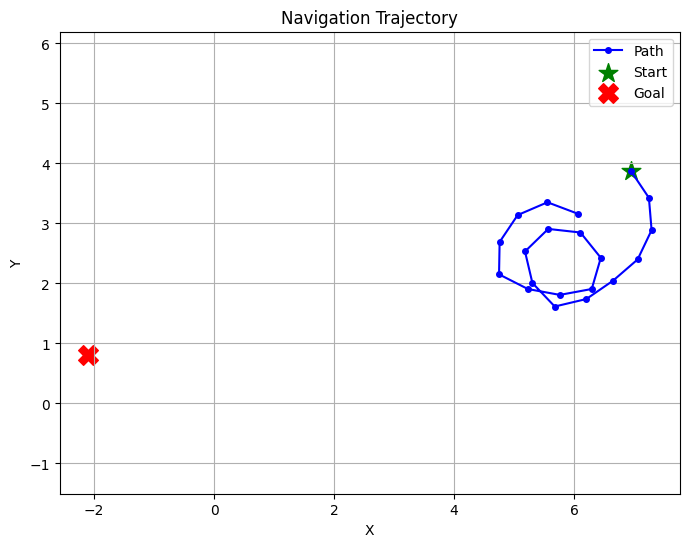

Epoch 500, Loss: 41.4816
tensor([7.5924, 2.3131], device='cuda:0') tensor([7.9000, 1.1495], device='cuda:0')


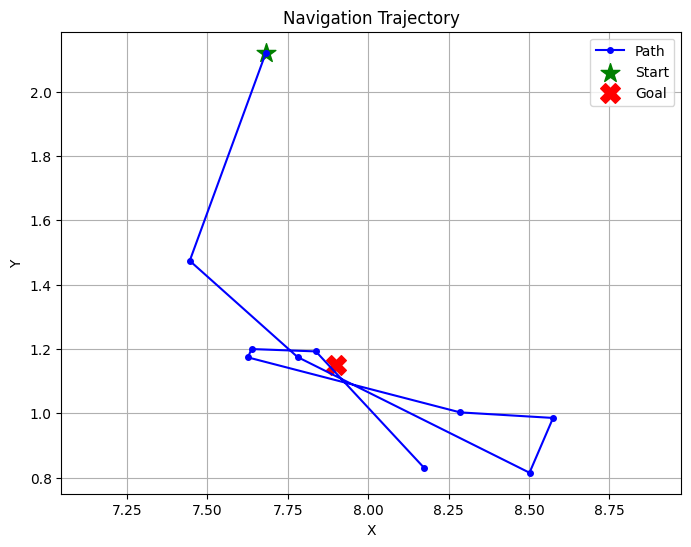

Epoch 1000, Loss: 55.3483
tensor([ 1.0887, -0.4237], device='cuda:0') tensor([3.3489, 5.7304], device='cuda:0')


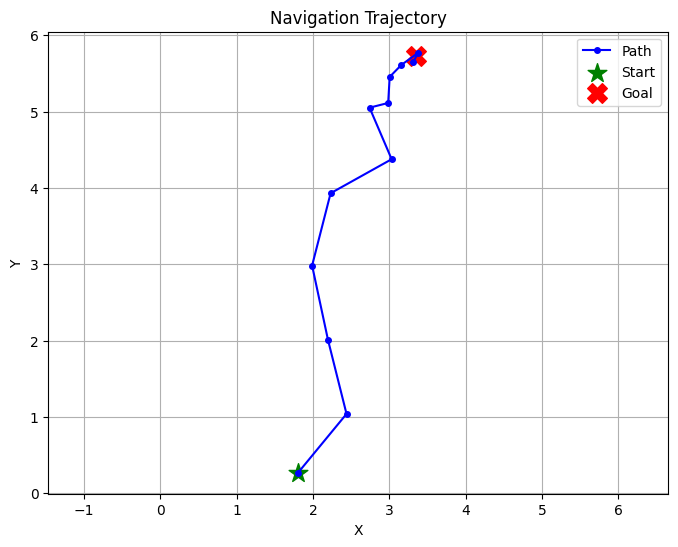

Epoch 1500, Loss: 61.3963
tensor([ 2.0806, -1.5232], device='cuda:0') tensor([ 7.9000, -5.9000], device='cuda:0')


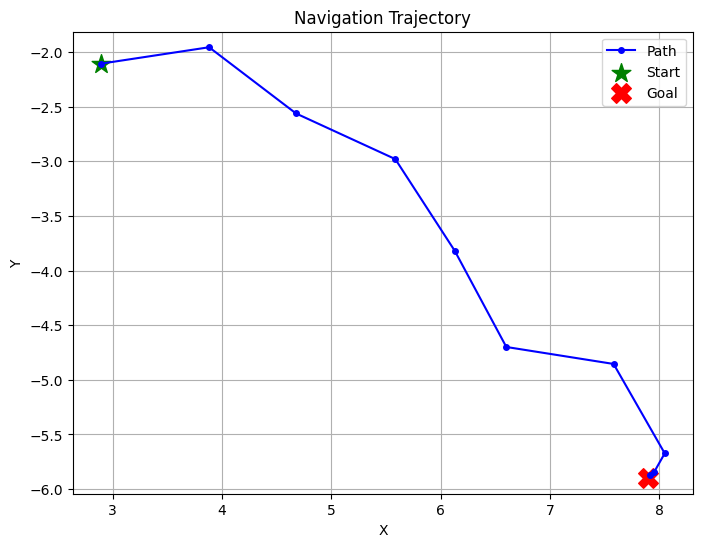

Epoch 2000, Loss: 163.4516
tensor([-0.5375, -5.3483], device='cuda:0') tensor([-1.4876,  5.9000], device='cuda:0')


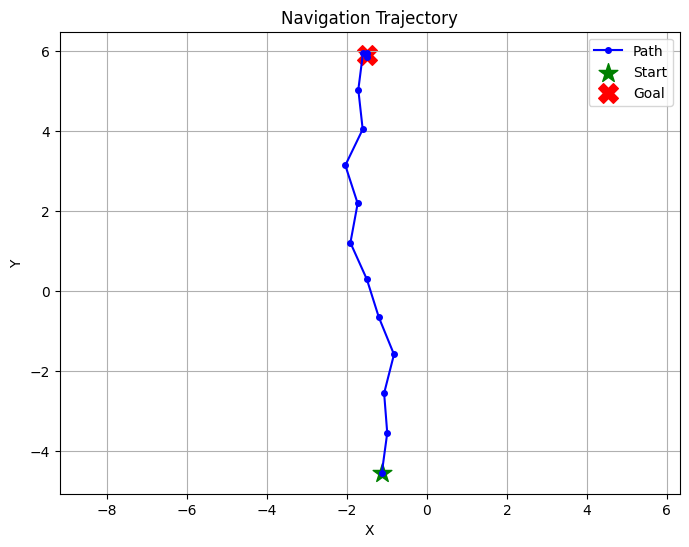

Epoch 2500, Loss: 38.6970
tensor([-5.3054, -1.0242], device='cuda:0') tensor([-7.9000,  3.9311], device='cuda:0')


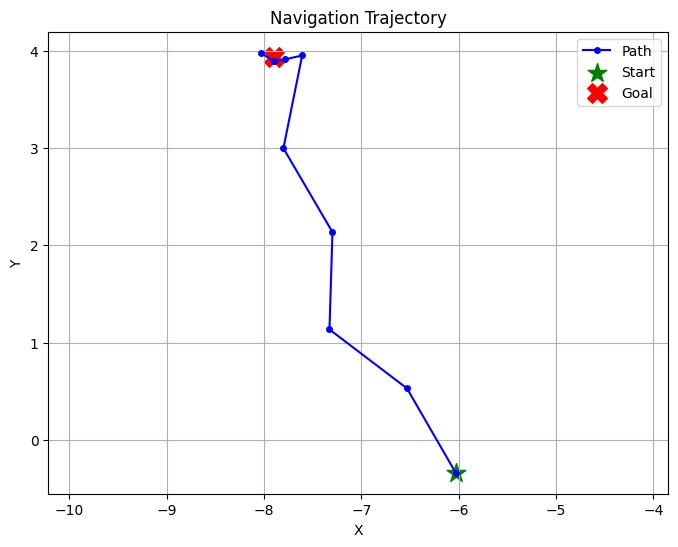

Epoch 3000, Loss: 162.8382
tensor([ 7.4517, -1.8669], device='cuda:0') tensor([0.1458, 5.9000], device='cuda:0')


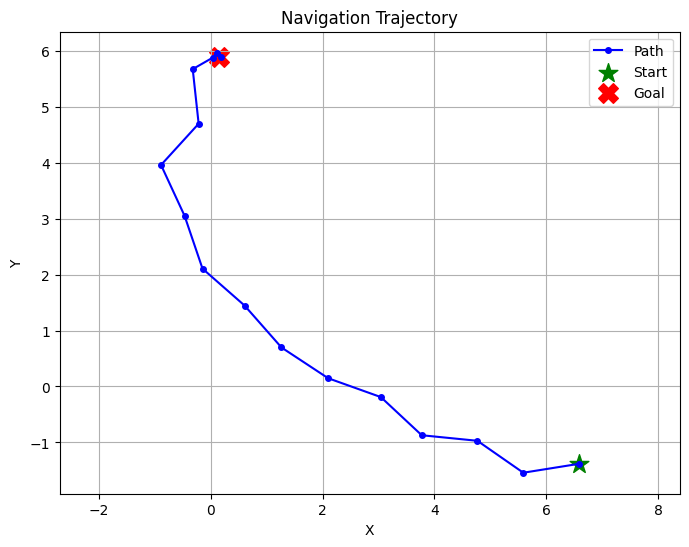

Epoch 3500, Loss: 63.5604
tensor([-2.7243,  3.3992], device='cuda:0') tensor([ 3.1093, -1.9841], device='cuda:0')


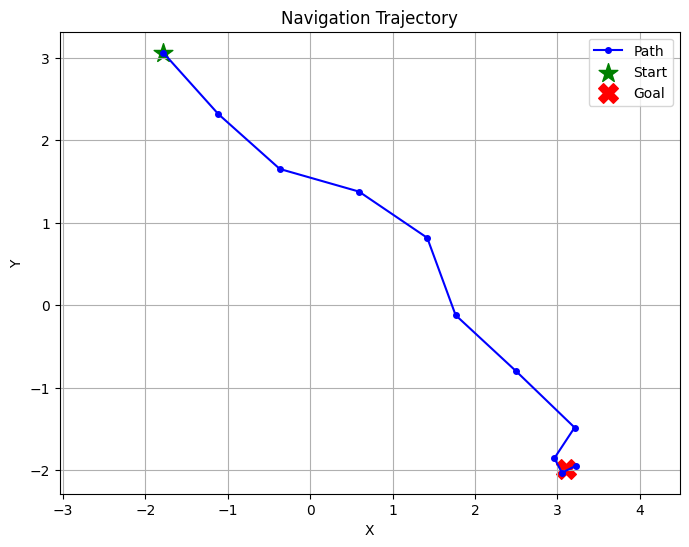

Epoch 4000, Loss: 23.2267
tensor([ 5.4371, -4.6091], device='cuda:0') tensor([ 7.9000, -5.9000], device='cuda:0')


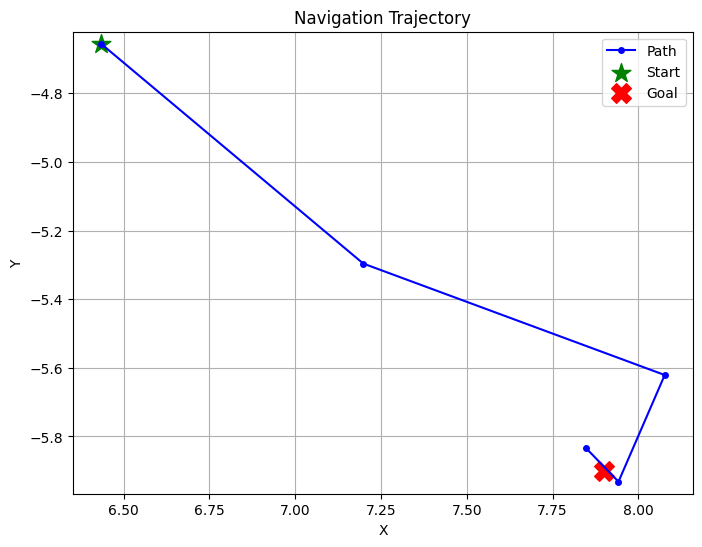

Epoch 4500, Loss: 125.4430
tensor([-2.4411, -2.0941], device='cuda:0') tensor([ 7.9000, -0.8708], device='cuda:0')


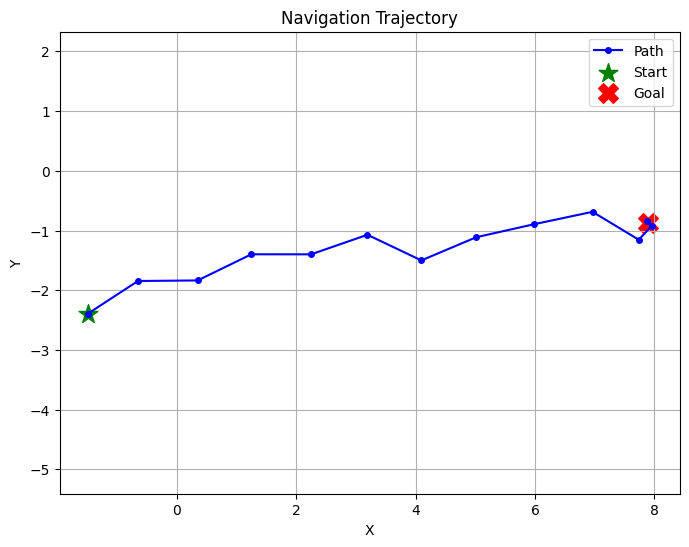

Epoch 5000, Loss: 140.1232
tensor([4.1346, 3.9404], device='cuda:0') tensor([ 7.9000, -5.9000], device='cuda:0')


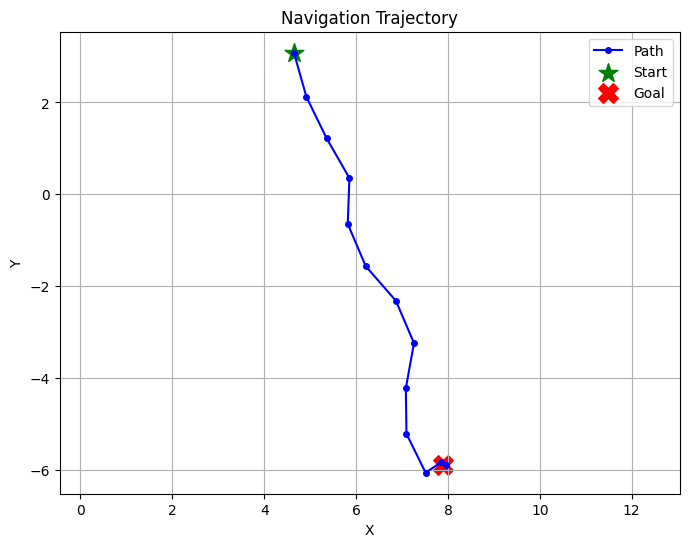

Epoch 5500, Loss: 78.1378
tensor([0.6661, 0.7633], device='cuda:0') tensor([-4.0623, -5.9000], device='cuda:0')


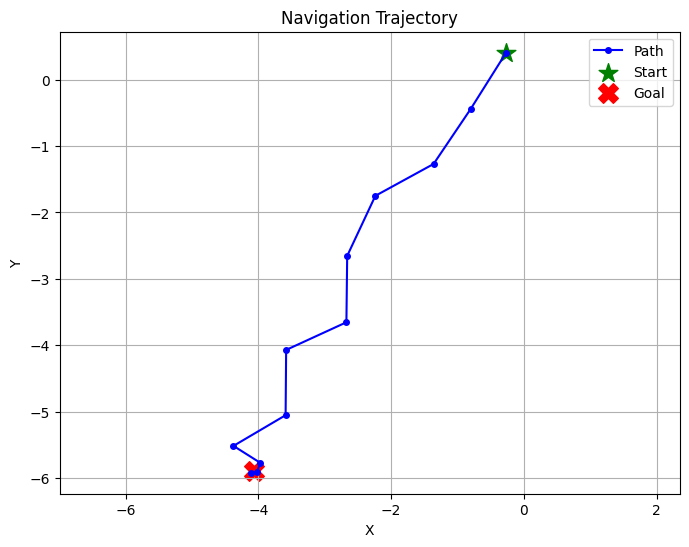

Epoch 6000, Loss: 102.8620
tensor([-5.1462,  1.2956], device='cuda:0') tensor([ 0.8739, -5.9000], device='cuda:0')


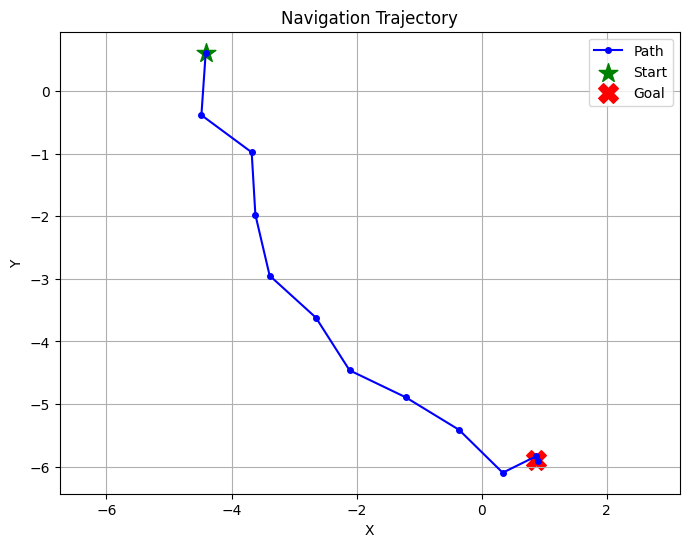

Epoch 6500, Loss: 55.3217
tensor([-3.7668, -0.1555], device='cuda:0') tensor([ 2.3832, -4.0771], device='cuda:0')


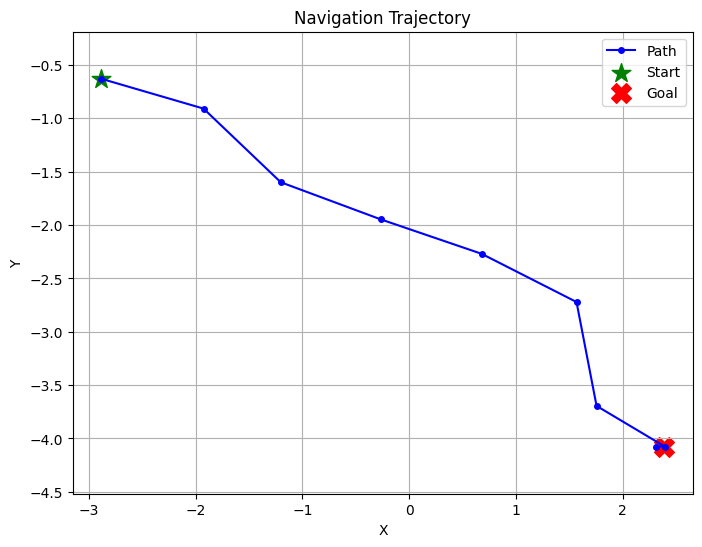

Epoch 7000, Loss: 140.8658
tensor([7.8880, 4.4874], device='cuda:0') tensor([ 7.9000, -5.9000], device='cuda:0')


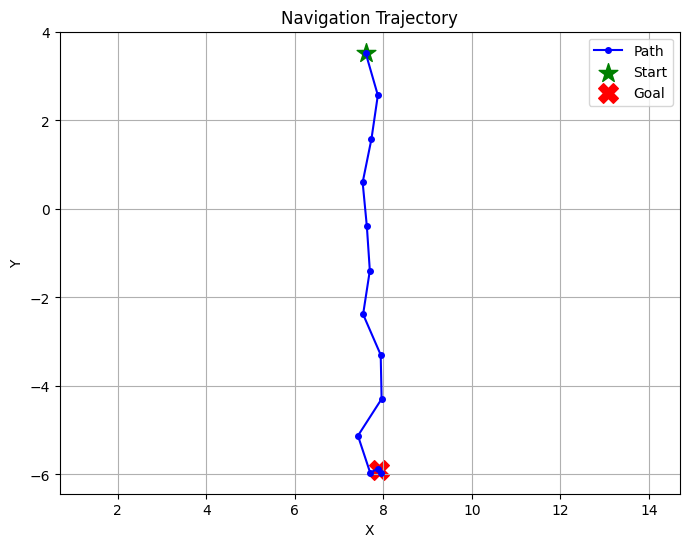

Epoch 7500, Loss: 25.9382
tensor([-2.7018,  4.4345], device='cuda:0') tensor([-6.2182,  5.9000], device='cuda:0')


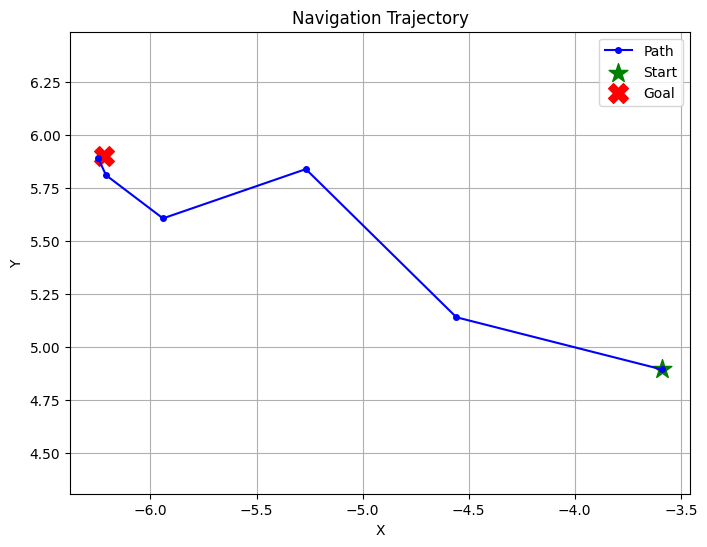

Epoch 8000, Loss: 151.5777
tensor([-6.1804, -5.5646], device='cuda:0') tensor([ 4.4408, -5.9000], device='cuda:0')


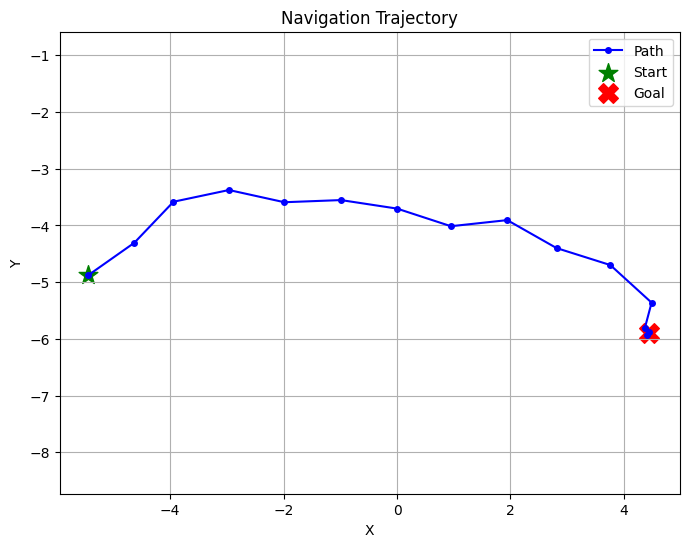

Epoch 8500, Loss: 256.0895
tensor([-5.4167,  4.3320], device='cuda:0') tensor([7.9000, 4.8764], device='cuda:0')


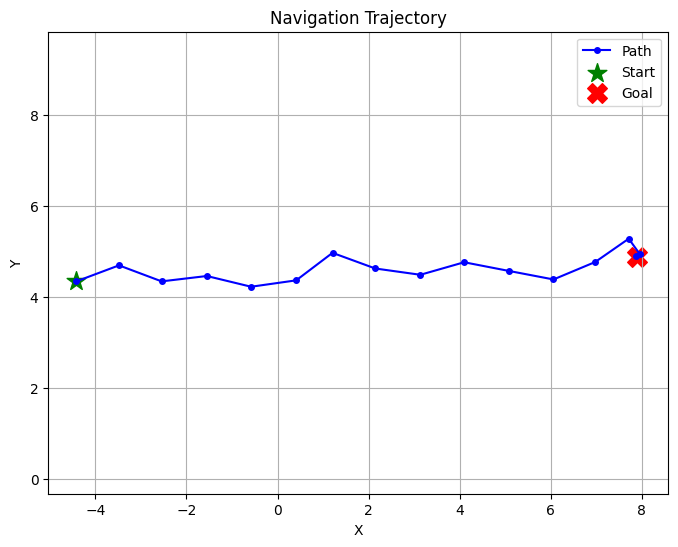

Epoch 9000, Loss: 42.7349
tensor([-4.6181, -3.7728], device='cuda:0') tensor([-1.5460,  1.5426], device='cuda:0')


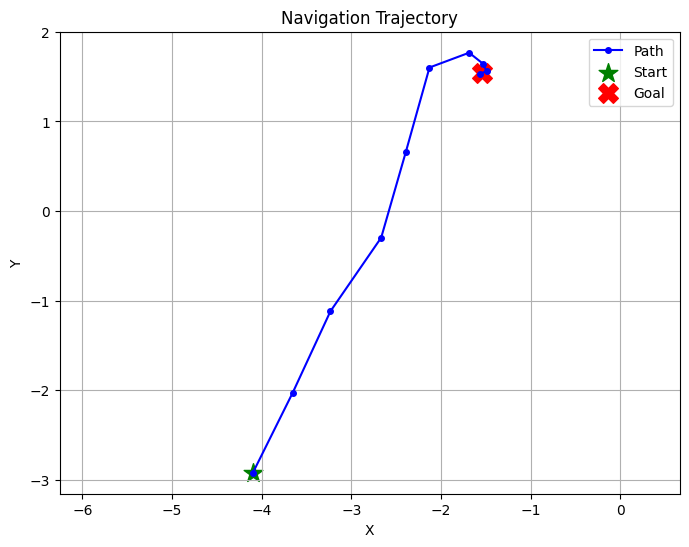

Epoch 9500, Loss: 20.6371
tensor([3.2918, 5.4295], device='cuda:0') tensor([-0.8049,  5.9000], device='cuda:0')


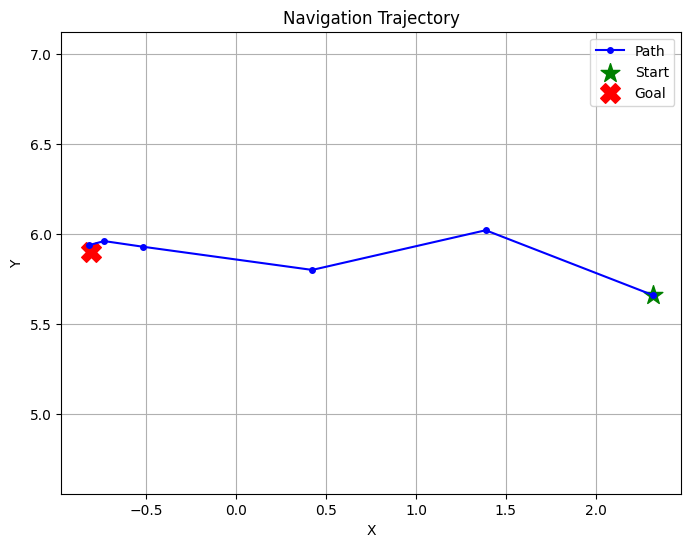

Epoch 10000, Loss: 53.8661
tensor([2.3699, 1.8268], device='cuda:0') tensor([7.9000, 5.9000], device='cuda:0')


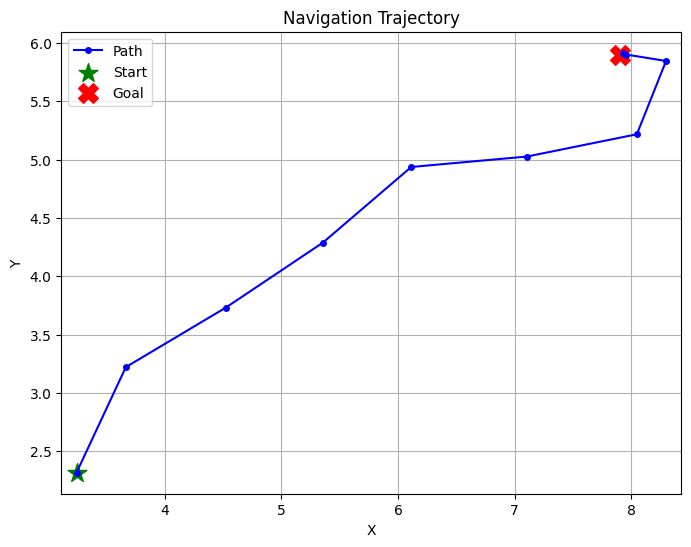

Epoch 10500, Loss: 125.6579
tensor([-6.5412,  1.9109], device='cuda:0') tensor([2.9860, 5.3142], device='cuda:0')


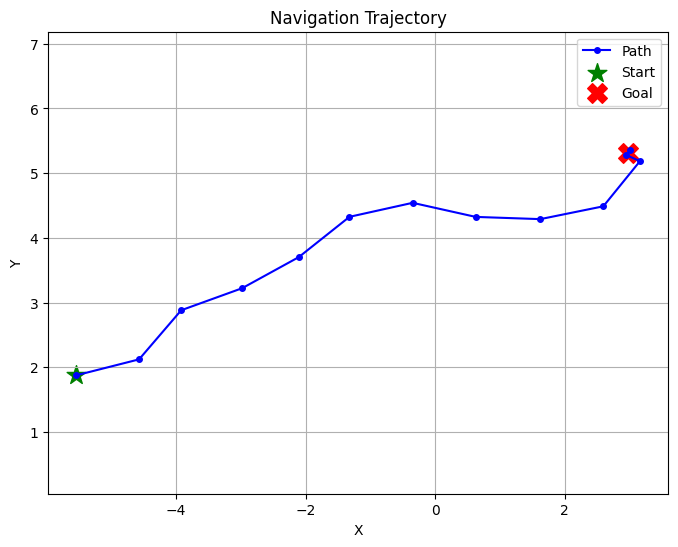

Epoch 11000, Loss: 24.1463
tensor([-6.0576,  4.5086], device='cuda:0') tensor([-1.6265,  5.4151], device='cuda:0')


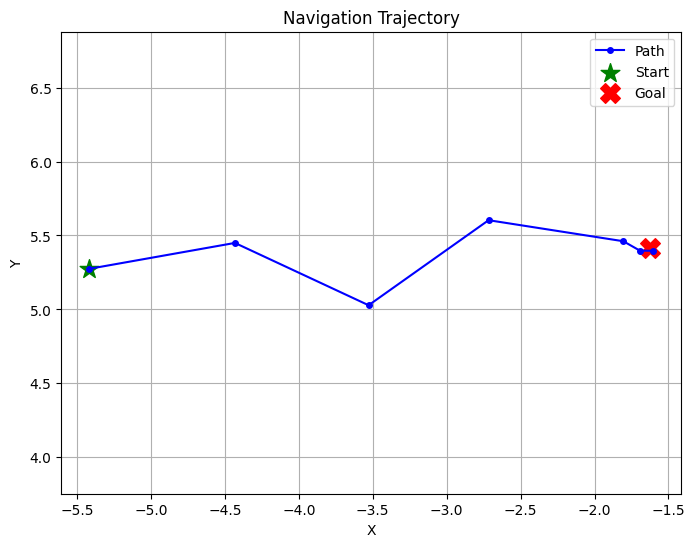

Epoch 11500, Loss: 75.8554
tensor([-5.3943,  1.9566], device='cuda:0') tensor([-7.9000, -5.9000], device='cuda:0')


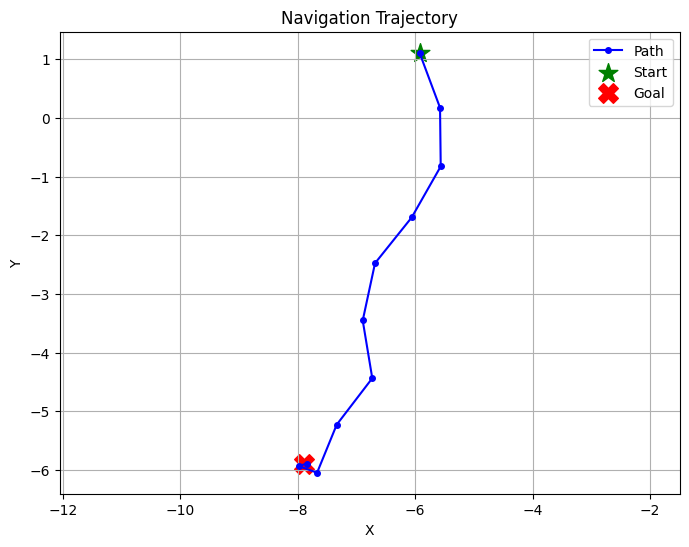

Epoch 12000, Loss: 126.9104
tensor([-3.4176,  0.5083], device='cuda:0') tensor([5.1899, 5.9000], device='cuda:0')


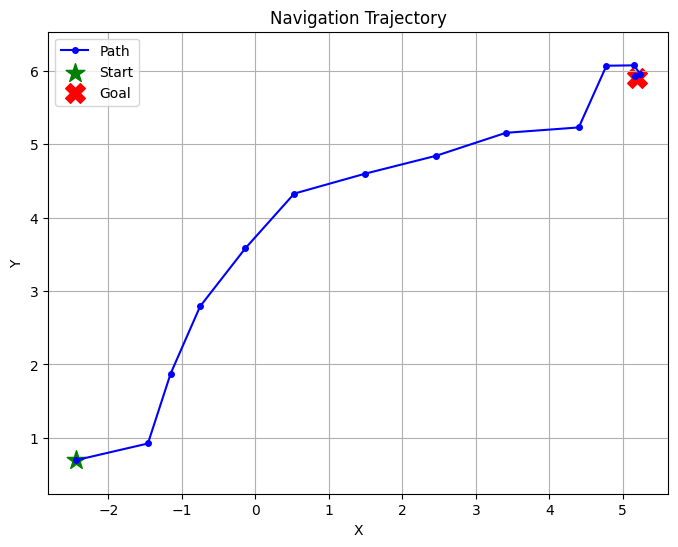

Epoch 12500, Loss: 119.6578
tensor([-2.0954,  3.7541], device='cuda:0') tensor([7.9000, 5.9000], device='cuda:0')


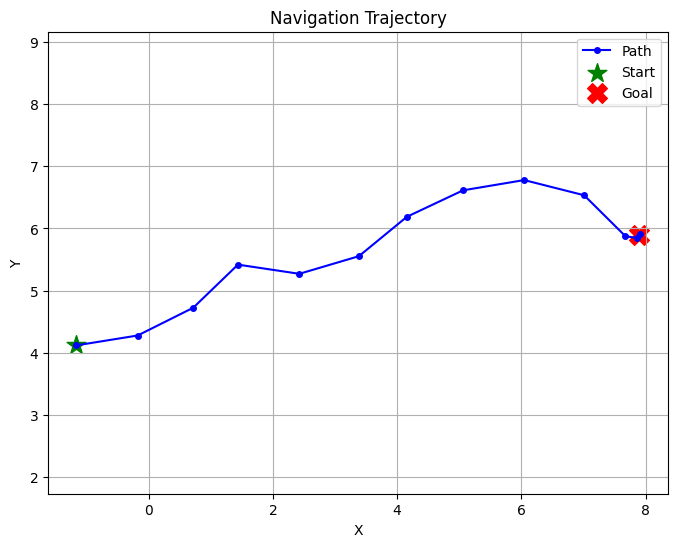

Epoch 13000, Loss: 321.1067
tensor([5.4193, 1.7637], device='cuda:0') tensor([-7.9000,  5.9000], device='cuda:0')


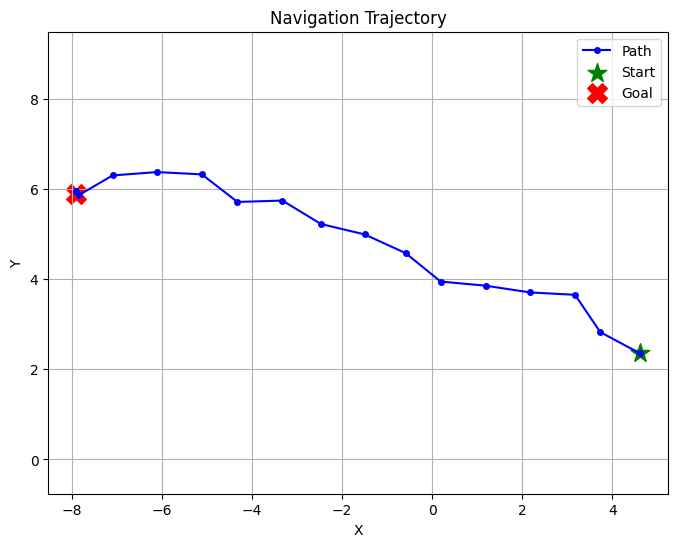

Epoch 13500, Loss: 83.4793
tensor([1.2338, 2.0248], device='cuda:0') tensor([7.9000, 5.9000], device='cuda:0')


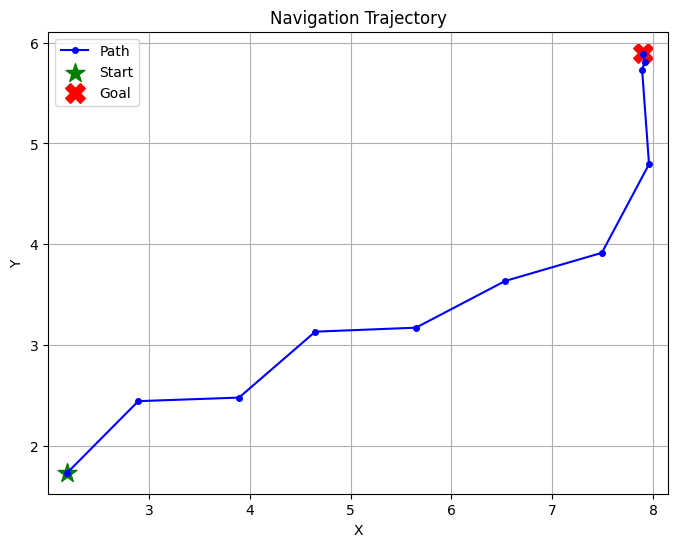

Epoch 14000, Loss: 30.7937
tensor([ 0.2232, -1.4642], device='cuda:0') tensor([-2.7424, -5.9000], device='cuda:0')


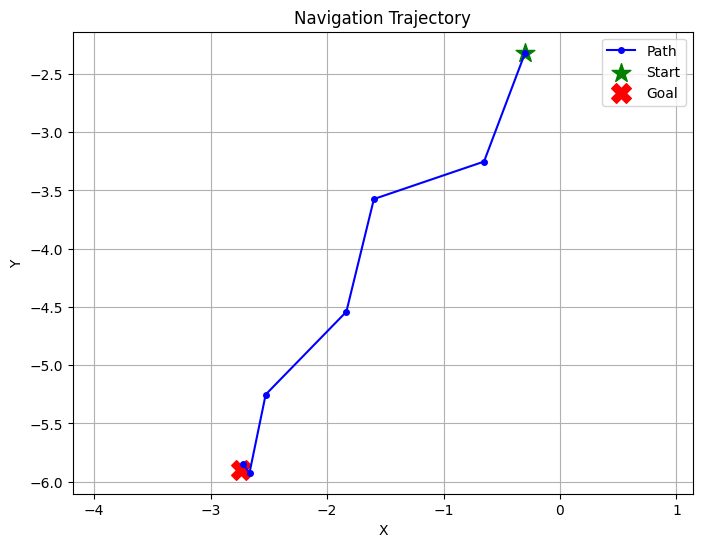

Epoch 14500, Loss: 147.0634
tensor([7.6778, 1.5078], device='cuda:0') tensor([-2.9012, -0.8186], device='cuda:0')


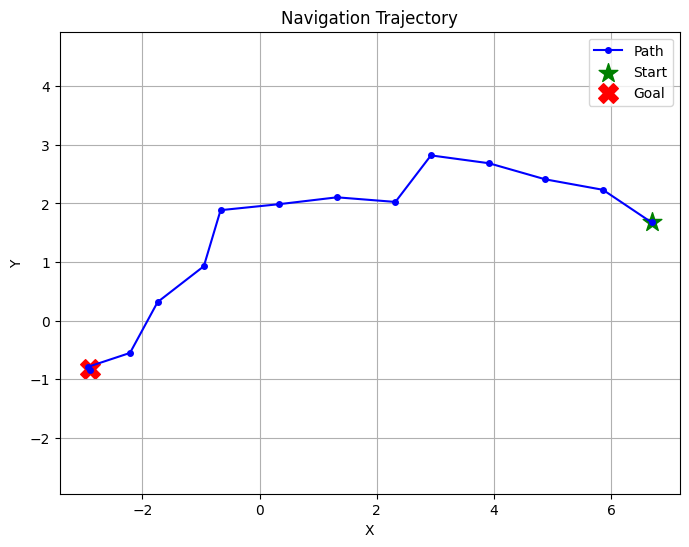

Epoch 15000, Loss: 442.4902
tensor([-7.3443,  5.2151], device='cuda:0') tensor([ 3.4564, -5.9000], device='cuda:0')


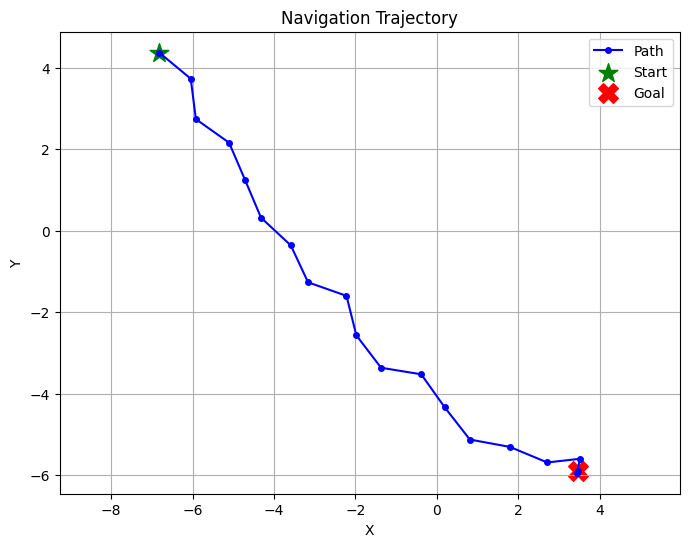

Epoch 15500, Loss: 29.7687
tensor([ 1.6955, -5.5532], device='cuda:0') tensor([-2.5018, -5.9000], device='cuda:0')


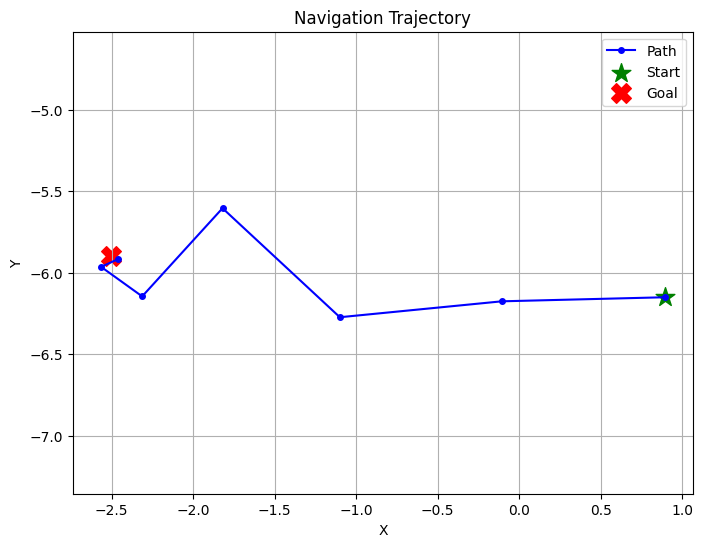

Epoch 16000, Loss: 42.2512
tensor([ 7.5036, -0.0456], device='cuda:0') tensor([7.9000, 5.9000], device='cuda:0')


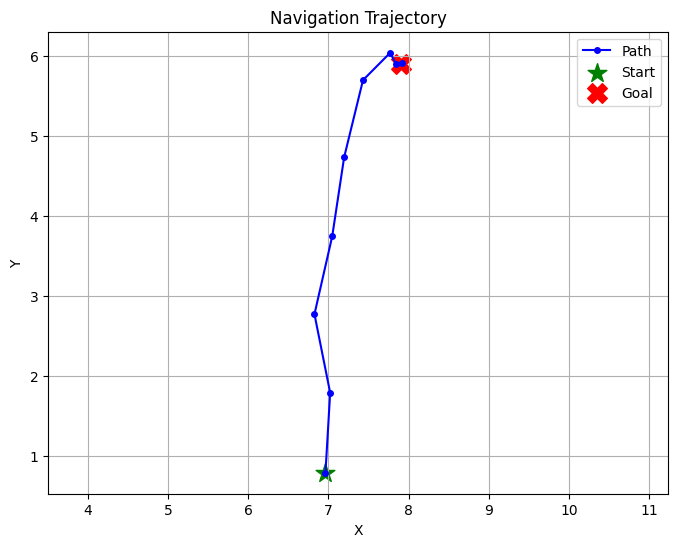

Epoch 16500, Loss: 152.4251
tensor([-3.3290, -4.1269], device='cuda:0') tensor([-7.9000,  5.6131], device='cuda:0')


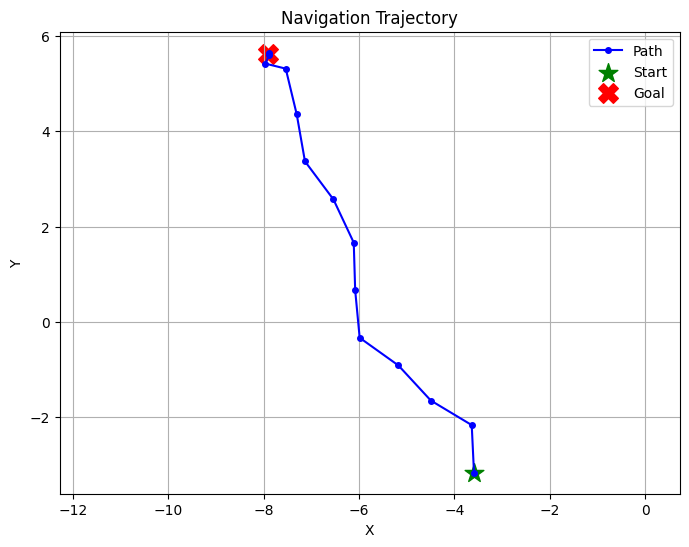

Epoch 17000, Loss: 122.2639
tensor([-1.6003, -5.2400], device='cuda:0') tensor([5.9338, 1.5057], device='cuda:0')


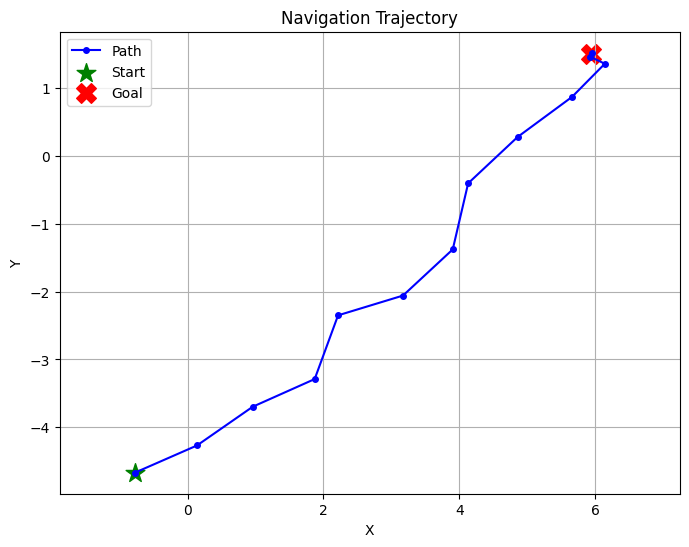

Epoch 17500, Loss: 156.6894
tensor([ 2.9563, -3.3634], device='cuda:0') tensor([-7.9000, -5.9000], device='cuda:0')


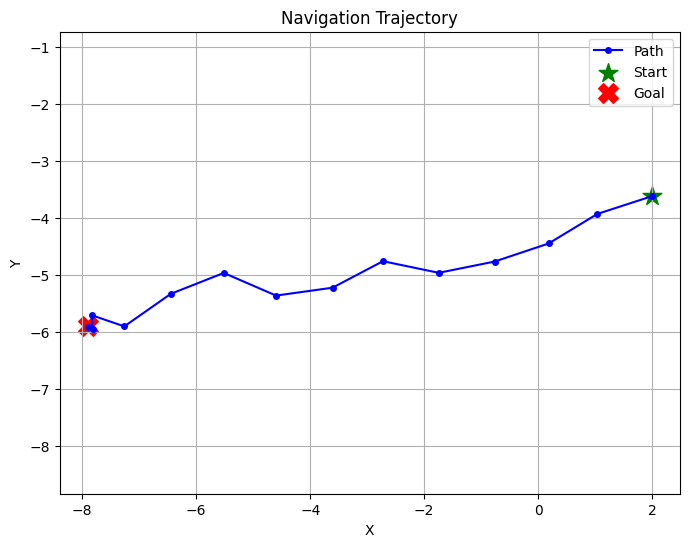

Epoch 18000, Loss: 80.6838
tensor([7.5255, 3.5663], device='cuda:0') tensor([ 7.9000, -4.6813], device='cuda:0')


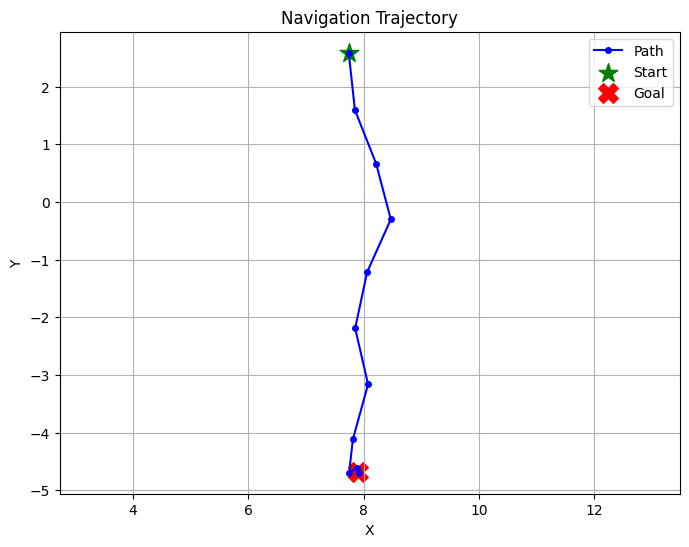

Epoch 18500, Loss: 99.0095
tensor([ 1.2944, -5.0629], device='cuda:0') tensor([-7.9000, -5.9000], device='cuda:0')


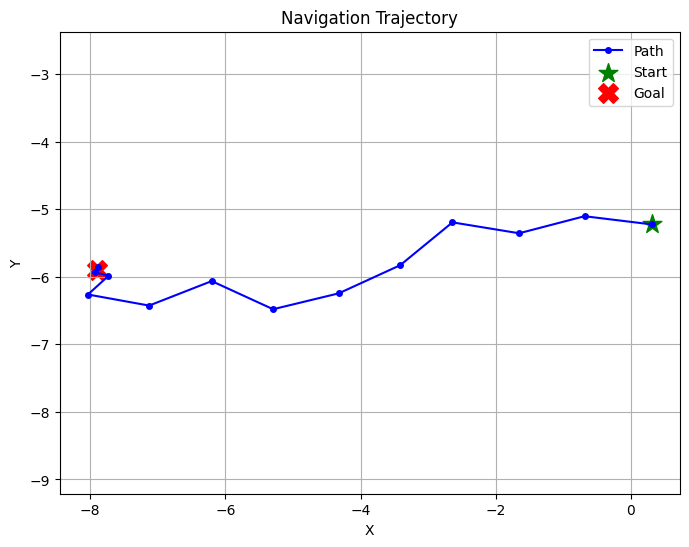

Epoch 19000, Loss: 83.8644
tensor([-0.6724,  0.3613], device='cuda:0') tensor([ 7.9000, -0.6794], device='cuda:0')


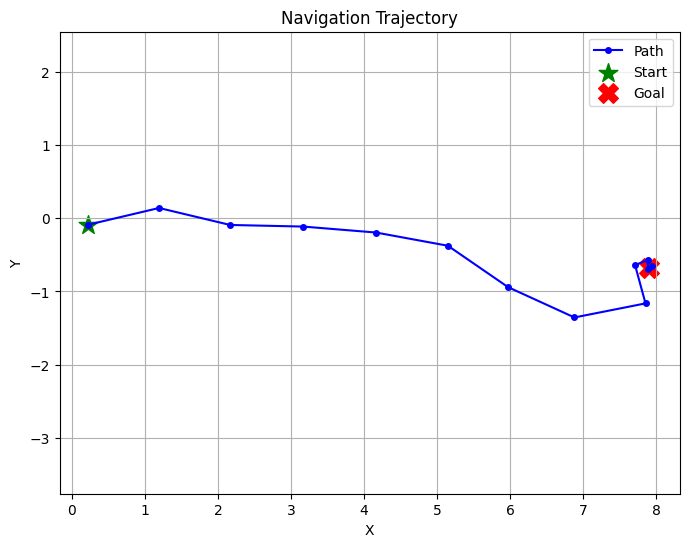

Epoch 19500, Loss: 73.1928
tensor([5.0602, 5.4411], device='cuda:0') tensor([-0.8539,  0.1085], device='cuda:0')


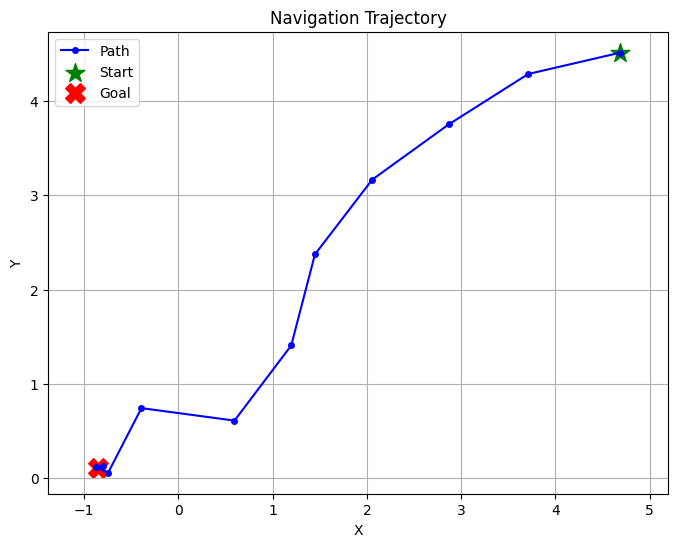

In [12]:
net = NavigationNet()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(20000):
    # Generate batch using PhiFlow
    initial_pos, goal_pos = generate_batch(512, min_distance=0.1, max_distance=10.0)

    optimizer.zero_grad()
    output = physics_loss(net, initial_pos, goal_pos)
    loss = output[0] if isinstance(output, tuple) else output
    total_loss = loss.sum  # Sum the loss to get a scalar

    # Skip backward and step if loss is NaN/Inf
    if not torch.isfinite(total_loss):
        print(f"Epoch {epoch}: Loss is NaN/Inf, skipping update.")
        continue

    total_loss.backward()  # Backpropagate

    # Clip gradients to prevent explosion (adjust max_norm as needed)
    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

    # Check for NaNs in gradients
    has_nan = False
    for p in net.parameters():
        if p.grad is not None and not torch.all(torch.isfinite(p.grad)):
            has_nan = True
            break

    if has_nan:
        print(f"Epoch {epoch}: NaN detected in gradients, skipping step.")
        optimizer.zero_grad()  # Clear gradients to prevent contamination
    else:
        optimizer.step()  # Update parameters if no NaNs

    # Logging and plotting
    if epoch % 500 == 0:
        with torch.no_grad():
            initial_pos, goal_pos = generate_batch(1, 4)
            initial_torch = initial_pos.native("samples,vector").squeeze(0)
            goal_torch = goal_pos.native("samples,vector").squeeze(0)

            loss = physics_loss(net, initial_pos, goal_pos)
            print(f"Epoch {epoch}, Loss: {loss.native().item():.4f}")

            plot_trajectory(net, initial_torch, goal_torch)

In [13]:
torch.save(net, 'new_noisy_nav_model.pth')

C:\Users\rahat\AppData\Local\Temp\ipykernel_34908\1578731868.py:56: DeprecationWarning: phiml.math.vec_squared is deprecated in favor of phiml.math.squared_norm
  control_change = math.vec_squared(controls - prev_controls)


tensor([ 4.5000, -3.2000]) tensor([ 2.1000, -6.1000])


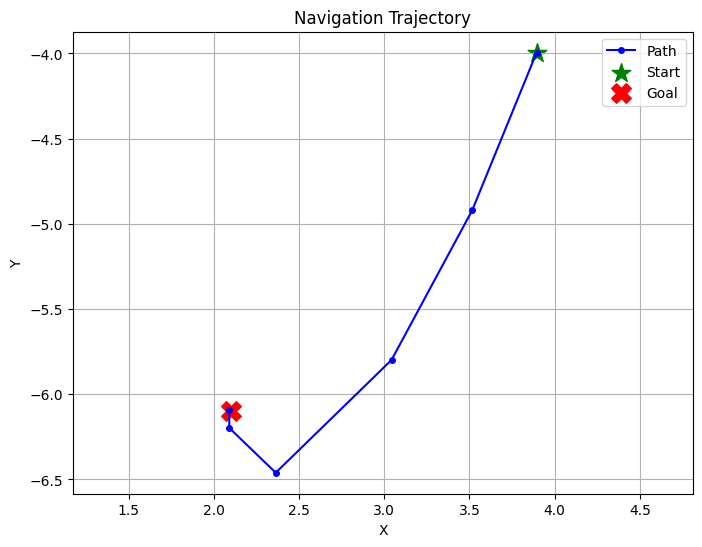

In [17]:
net = torch.load(r'F:\Aerosim-Simulation-Zone\Try\new_noisy_nav_model.pth', weights_only=False)
with torch.no_grad():
    initial_torch = torch.tensor([4.5, -3.2], dtype=torch.float32)
    goal_torch = torch.tensor([2.1, -6.1], dtype=torch.float32)

    loss = physics_loss(net, initial_pos, goal_pos)
    # print(f"Epoch {epoch}, Loss: {loss.native().item():.4f}")
    plot_trajectory(net, initial_torch, goal_torch, 60)

In [ ]:
net = torch.load('nav_model.pth')